kmeans - separate xu and liu, either into their own clusters of separate depending on n

DBSCAN- separates esa, gfw, ltgnn

OPTICS - nothing separated

In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [2]:
# Load the dataset
biomass_data_AZ = pd.read_csv('agb_AZ_final.csv')
biomass_data_CA = pd.read_csv('agb_CA.csv')

biomass_data=biomass_data_AZ.append(biomass_data_CA, ignore_index=True)
biomass_data

#Drop the year column
biomass_data = biomass_data.drop('year', axis=1)

In [ ]:
biomass_data_CA

In [ ]:
biomass_data_AZ

In [ ]:
biomass_data

In [14]:
# !pip install geopandas matplotlib
import geopandas as gpd
from shapely.geometry import Point

# Replace 'NA' with NaN
df = biomass_data.replace('NA', np.nan)

# Drop rows with all NaN values
df = df.dropna()

#Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
)


In [15]:
df

,product,agb_Mg_ha,IGBP_Class,Longitude,Latitude,IGBP_Name,ffp_radius
1,chopping,-9999.000000,1,-115.103417,35.283820,Evergreen Needleleaf Forest,1
3,chopping,-9999.000000,1,-108.709532,33.620168,Evergreen Needleleaf Forest,1
4,chopping,0.000000,1,-112.648381,32.127377,Evergreen Needleleaf Forest,1
6,chopping,10.909091,1,-111.749101,33.458299,Evergreen Needleleaf Forest,1
9,chopping,0.000000,1,-112.882194,36.749633,Evergreen Needleleaf Forest,1
...,...,...,...,...,...,...,...
102540,xu,234.518311,16,-123.988309,40.058952,Barren or Sparsely Vegetated,1
102542,xu,207.423889,16,-119.860612,38.341344,Barren or Sparsely Vegetated,1
102543,xu,45.446182,16,-118.196942,37.010422,Barren or Sparsely Vegetated,1
102547,xu,220.309723,16,-121.776079,40.202836,Barren or Sparsely Vegetated,1


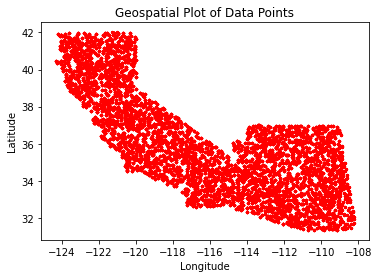

In [16]:
# Plot the data
gdf.plot(marker='o', color='red', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Plot of Data Points')
plt.show()

In [17]:
df=biomass_data

# Get unique product categories
unique_products = df['product'].unique()

# Create a dictionary to store separate dataframes
product_dfs = {}

# Separate the dataframe for each unique product
for product in unique_products:
    product_dfs[product] = df[df['product'] == product].copy()
    
    # Reset index for each separated dataframe
    product_dfs[product].reset_index(drop=True, inplace=True)

In [18]:
#Combine agb data for all products into one dataframe, locations on rows, products on cols

# Create an empty dataframe to store the combined 'agb_MG_ha' columns
combined_df = pd.DataFrame()

# Append 'agb_MG_ha' column for each product category into the combined dataframe
for product in unique_products:
    # Extract the 'agb_MG_ha' column for the current product category
    product_agb = product_dfs[product]['agb_Mg_ha'].reset_index(drop=True)
    
    # Rename the column to indicate the product category
    product_agb.name = f'{product}'
    
    # Append the column to the combined dataframe
    combined_df = pd.concat([combined_df, product_agb], axis=1)

In [24]:
# Prep data for clustering

# Remove non-numeric rows
data_transposed_numeric = combined_df.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

In [25]:
data_imputed

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
1,-9999.000000,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.500000,-7498.500000
2,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
4,0.000000,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.000000,7.759220
...,...,...,...,...,...,...,...,...,...,...
10791,302.545441,293.200012,296.273346,431.000000,987.000000,233.294724,554.041753,302.653900,1798.470093,341.938263
10792,0.000000,6.000000,15.617992,18.459537,39.000000,10.028250,18.459537,1.476027,0.000000,75.554024
10794,-908.727295,0.000000,1.624960,-110.137969,7.000000,9.612687,-110.137969,0.906262,0.000000,8.479631
10798,0.000000,0.000000,3.049171,2.522635,4.000000,8.420034,2.522635,0.000000,0.000000,4.711873


In [26]:
#transpose dataset for clustering
data_transposed = data_imputed.T
data_transposed

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed)

# Kmeans

In [28]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.2403
Calinski-Harabasz Index: 3.3760
Davies-Bouldin Index: 1.4499
---
n_clusters = 3
Silhouette Index: 0.2085
Calinski-Harabasz Index: 3.1382
Davies-Bouldin Index: 1.0460
---
n_clusters = 4
Silhouette Index: 0.1984
Calinski-Harabasz Index: 3.1027
Davies-Bouldin Index: 0.4753
---
n_clusters = 5
Silhouette Index: 0.1954
Calinski-Harabasz Index: 3.8166
Davies-Bouldin Index: 0.4320
---
n_clusters = 6
Silhouette Index: 0.1795
Calinski-Harabasz Index: 5.2098
Davies-Bouldin Index: 0.3854
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.2403
Calinski-Harabasz Index - Optimal n_clusters: 6, Best Calinski-Harabasz Index: 5.2098
Davies-Bouldin Index - Optimal n_clusters: 6, Best Davies-Bouldin Index: 0.3854


Cluster labels: [0 0 0 0 0 1 0 0 0 2]
Distances between cluster centers:
[[  0.         110.21226811  88.96238464]
 [110.21226811   0.         107.56188502]
 [ 88.96238464 107.56188502   0.        ]]

Distances between data points and cluster centers:
Data point 0: [ 68.70172655 140.28437408 126.95178998]
Data point 1: [ 37.46888562 123.19469016 102.55227617]
Data point 2: [ 45.83234752 110.6153248   91.70415665]
Data point 3: [26.49166319 99.10757011 80.56199361]
Data point 4: [ 74.54042226 118.84647469 102.38745525]
Data point 5: [110.21226811   0.         107.56188502]
Data point 6: [ 26.72686777 109.9058964   88.96968163]
Data point 7: [ 39.84517191 117.35390872  97.21109969]
Data point 8: [ 68.9181362  147.70825348 124.363357  ]
Data point 9: [ 88.96238464 107.56188502   0.        ]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


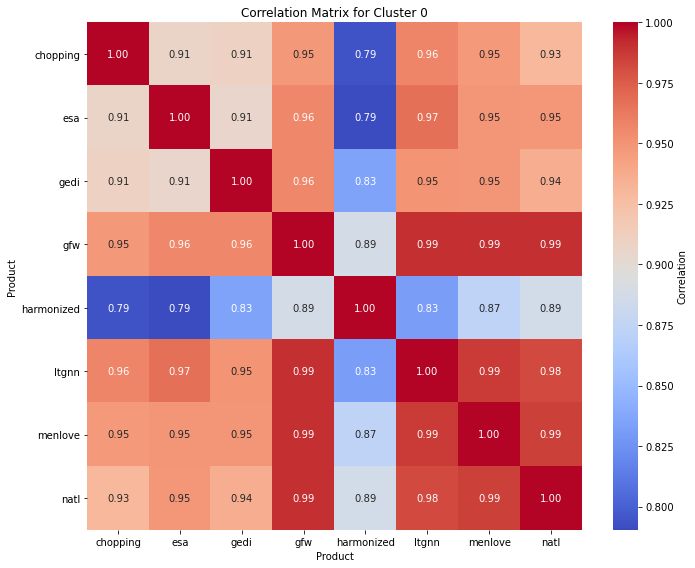

Silhouette Coefficient: 0.2080831143756769
Calinski-Harabasz Index: 2.7964945928641303
Davies-Bouldin Index: 0.5108266822382287


In [31]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

# DBSCAN

In [32]:
# Define the range of values for eps and min_samples
eps_values = np.arange(20, 50, 2)
min_samples_values = range(4, 5)

# Initialize variables to store the best results for each index
best_eps_silhouette = 0
best_min_samples_silhouette = 0
best_silhouette = -1.0

best_eps_calinski_harabasz = 0
best_min_samples_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_eps_davies_bouldin = 0
best_min_samples_davies_bouldin = 0
best_davies_bouldin = float('inf')

min_samples=2
for eps in eps_values:
#     for min_samples in min_samples_values:
    print(f"eps = {eps:.2f}, min_samples = {min_samples}")

    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters_d = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the transposed DataFrame
    data_transposed.loc[:,'cluster'] = clusters_d
    print(clusters_d)

    # Transpose the data back to the original format
    biomass_data_clustered_d = data_imputed.reset_index()

    # Check for noise points
    if -1 in clusters_d:
        print("Noise found during clustering, contained in cluster -1")

    # Compute evaluation metrics
    if len(set(clusters_d)) > 1:  # Check if there are at least two clusters
        silhouette = silhouette_score(data_scaled, clusters_d)
        calinski_harabasz = calinski_harabasz_score(data_scaled, clusters_d)
        davies_bouldin = davies_bouldin_score(data_scaled, clusters_d)

        print(f"Silhouette Index: {silhouette:.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

        # Update the best results for Silhouette Index
        if silhouette > best_silhouette:
            best_eps_silhouette = eps
            best_min_samples_silhouette = min_samples
            best_silhouette = silhouette

        # Update the best results for Calinski-Harabasz Index
        if calinski_harabasz > best_calinski_harabasz:
            best_eps_calinski_harabasz = eps
            best_min_samples_calinski_harabasz = min_samples
            best_calinski_harabasz = calinski_harabasz

        # Update the best results for Davies-Bouldin Index
        if davies_bouldin < best_davies_bouldin:
            best_eps_davies_bouldin = eps
            best_min_samples_davies_bouldin = min_samples
            best_davies_bouldin = davies_bouldin
    else:
        print("Skipping evaluation metrics as there is only one cluster")

    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal eps: {best_eps_silhouette:.2f}, Optimal min_samples: {best_min_samples_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal eps: {best_eps_calinski_harabasz:.2f}, Optimal min_samples: {best_min_samples_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal eps: {best_eps_davies_bouldin:.2f}, Optimal min_samples: {best_min_samples_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

eps = 20.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 22.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 24.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 26.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 28.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1
Skipping evaluation metrics as there is only one cluster
---
eps = 30.00, min_samples = 2
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Noise found during clustering, contained in cluster -1

Cluster labels: [-1  0 -1  0 -1 -1  0 -1 -1 -1]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster -1 contains multiple products, plotting heatmap...
Cluster 0 contains multiple products, plotting heatmap...


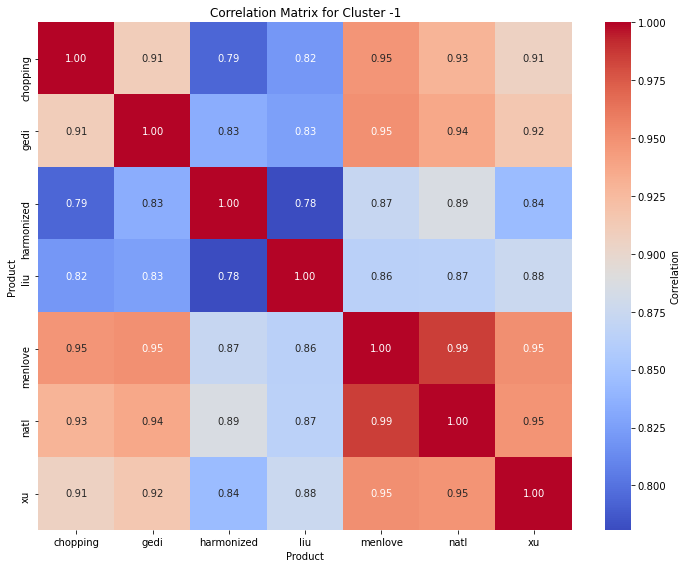

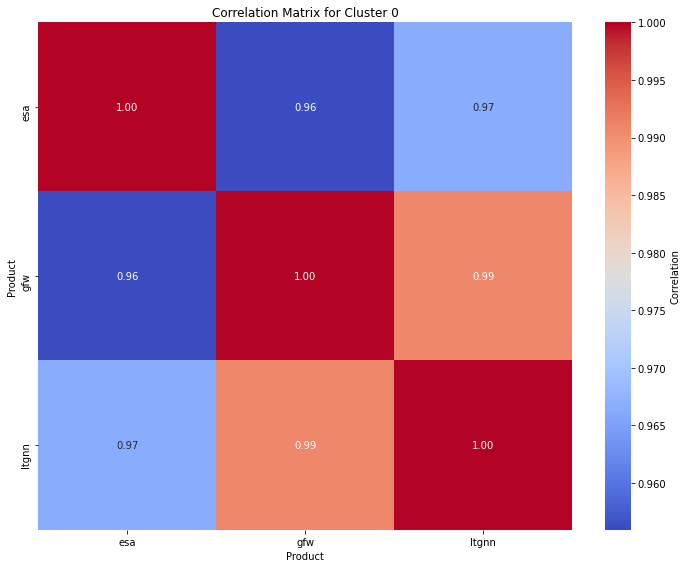

In [34]:
# DBSCAN clustering
dbscan = DBSCAN(eps=42, min_samples=2)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(data_scaled)
labels = dbscan.labels_
print("Cluster labels:", clusters)

# cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
# predicted_labels = biomass_data_clustered['cluster']
# print_indices(data_scaled, predicted_labels)

# OPTICS

OPTICS Cluster labels: [0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[0.]]

Distances between data points and cluster centers:
Data point 0: [75.0666934]
Data point 1: [44.40658093]
Data point 2: [44.99382092]
Data point 3: [21.72835744]
Data point 4: [72.00838569]
Data point 5: [95.67534457]
Data point 6: [29.16113536]
Data point 7: [43.26342999]
Data point 8: [76.20751462]
Data point 9: [75.94617193]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


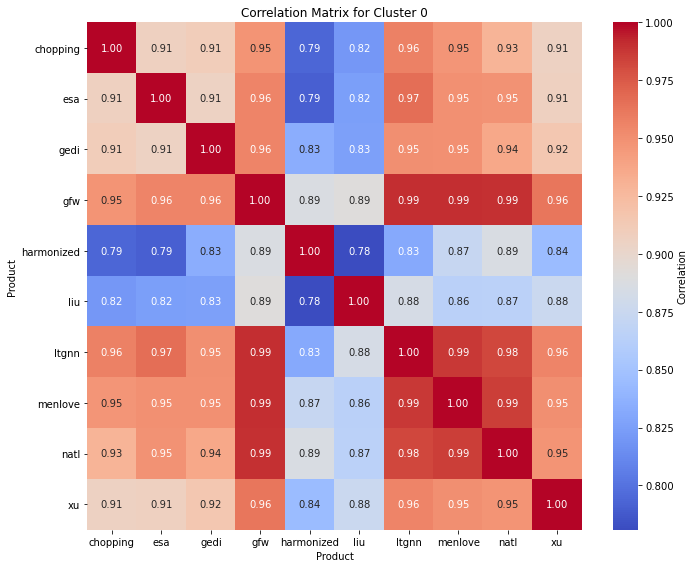

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [35]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)